In [285]:
import keras
from keras.layers import Input, Dense, Concatenate
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, Conv2D, MaxPooling1D, MaxPooling2D
from keras.optimizers import SGD
from keras import initializers
from keras.regularizers import l2

import player
import game
import neural_network
import mcts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import board as b
import keras
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import pandas as pd
import numpy as np
from copy import deepcopy

Instructions for updating:
non-resource variables are not supported in the long term


In [218]:
model = keras.models.load_model("./best_keras_model.tf")
data = pd.read_csv("training_data.csv")

X_str = data["init_state"].values
X_clean = np.array([b.Board.str2arr(x) for x in X_str])

Y_value = data["Value"].values
targets = (Y_value + 1).round()
Y_value_one_hot = np.eye(3)[targets.astype(int)]

In [246]:
data["Value"].value_counts()

 1    2936
-1    1474
 0    1068
Name: Value, dtype: int64

In [259]:
data.groupby("Value").apply(lambda x: x.sample(2))


init_state  Value
Value                       
-1    5425  xx o oxox     -1
      5087  xxo  xo o     -1
 0    1148  oxxx o         0
      398   xoxxxoo        0
 1    2646  xoo x xox      1
      320   x x o x o      1

In [358]:

Input_1 = Input(shape=(3, 3, 1))

x1 = Conv2D(filters=3, kernel_size=(1, 3), activation='relu',
            kernel_regularizer=l2(0.005),
            kernel_initializer=initializers.RandomNormal(stddev=0.1, mean=0),
            input_shape=(3, 3, 1))(Input_1)

x2 = Conv2D(filters=3, kernel_size=(3, 1), activation='relu',
            kernel_regularizer=l2(0.005),
            kernel_initializer=initializers.RandomNormal(stddev=0.1, mean=0),
            input_shape=(3, 3, 1))(Input_1)

x3 = Conv2D(filters=4, kernel_size=(3, 3), activation='relu',
            kernel_regularizer=l2(0.005),
            kernel_initializer=initializers.RandomNormal(stddev=0.1, mean=0),
            input_shape=(3, 3, 1))(Input_1)

x1 = MaxPooling2D((3, 1))(x1)
x2 = MaxPooling2D((1, 3))(x2)
x3 = MaxPooling2D((1, 1))(x3)

x = Concatenate()([x1, x2, x3])
x = Flatten()(x)

value_head = Dense(100, activation='relu')(x)
value_head = Dense(10, activation='relu')(x)
value_head = Dense(3, activation='softmax', name="V")(x)

model = Model(inputs=Input_1, outputs=value_head)
model.compile(optimizer="adam",
                     loss= "categorical_crossentropy",
                     metrics=['acc'])


In [356]:
Y_value+1

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
iterations= 50

for i in range(iterations):
    sample = data.groupby("Value").apply(lambda x: x.sample(1000))

    X_str = sample["init_state"].values
    X_clean = [b.Board.str2arr(x) for x in X_str]

    X_augmented = deepcopy(X_clean)
    for k in range(1,4):
        X_augmented+=[np.rot90(state, k=k) for state in X_clean]

    Y_value = sample["Value"].values 
    Y_augmented = np.tile(Y_value,4)
    targets = (Y_augmented + 1).round()
    Y_value_one_hot = np.eye(3)[targets.astype(int)]



    X_final = np.stack([X_augmented], axis=-1)
    model.fit(X_final, Y_augmented, epochs=10, verbose=1)

Train on 12000 samples
Epoch 1/10
12000/12000 [==============================] - 0s 34us/sample - loss: 0.6676 - acc: 0.3333
Epoch 2/10
12000/12000 [==============================] - 0s 27us/sample - loss: 0.6433 - acc: 0.3341
Epoch 3/10
12000/12000 [==============================] - 0s 27us/sample - loss: 0.6110 - acc: 0.3472
Epoch 4/10
12000/12000 [==============================] - 0s 26us/sample - loss: 0.5969 - acc: 0.3655
Epoch 5/10
12000/12000 [==============================] - 0s 26us/sample - loss: 0.5870 - acc: 0.3788
Epoch 6/10
12000/12000 [==============================] - 0s 26us/sample - loss: 0.5802 - acc: 0.3882
Epoch 7/10
12000/12000 [==============================] - 0s 26us/sample - loss: 0.5756 - acc: 0.3943
Epoch 8/10
12000/12000 [==============================] - 0s 26us/sample - loss: 0.5723 - acc: 0.3985
Epoch 9/10
12000/12000 [==============================] - 0s 27us/sample - loss: 0.5694 - acc: 0.4041
Epoch 10/10
12000/12000 [==============================] - 

In [353]:
model.save("./best_keras_model.tf")


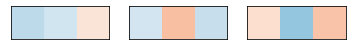

array([[-0.16631162,  0.39002407, -0.2856844 ]], dtype=float32)

In [340]:
filters = model.layers[1].get_weights()[0]
f_min, f_max = filters.min(), filters.max()
n_filters, ix = 3 , 1

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='RdBu', vmin = -1, vmax = 1)
        ix += 1

# show the figure
plt.show()
f[:, :, j]

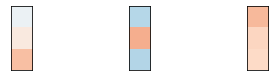

array([[-0.3262563 ],
       [-0.2132899 ],
       [-0.19896498]], dtype=float32)

In [339]:
filters = model.layers[2].get_weights()[0]
f_min, f_max = filters.min(), filters.max()
n_filters, ix = 3 , 1

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='RdBu', vmin = -1, vmax = 1)
        ix += 1

# show the figure
plt.show()
f[:, :, j]

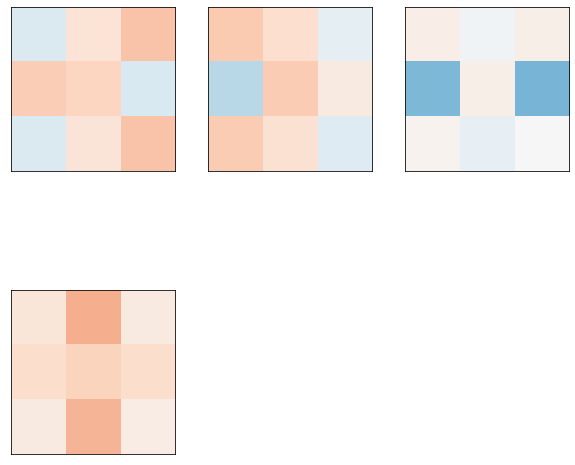

array([[-0.11883822, -0.36287555, -0.09135641],
       [-0.17673668, -0.22344571, -0.1796872 ],
       [-0.08874785, -0.34374246, -0.07226069]], dtype=float32)

In [338]:
filters = model.layers[3].get_weights()[0]
f_min, f_max = filters.min(), filters.max()
n_filters, ix = 4, 1

fig, ax = plt.subplots(figsize=(10, 20))

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='RdBu', vmin = -1, vmax = 1)
        ix += 1

# show the figure


plt.show()

f[:, :, j]

In [349]:
test = np.array([[ 0,  0,  0],
                 [ 0,  -1, 0],
                 [ 1,  0, 0]])

n_map = {-1:"o", 0: " ", 1: "x"}

str_state = ''.join([n_map[i] for i in test.reshape(9,)])
str_state
inp = np.stack([[test]], axis=-1)
               
pred = model.predict(inp)
lose, draw, win = pred[0]
pred = model.predict(inp)
print(pred)
print((win)/(win+lose))
print((lose)/(win+lose))

data[data["init_state"]==str_state]

[[0.02398615 0.6648612  0.31115267]]
0.9284292
0.071570784


,init_state,Value
3630,o x,0


In [350]:
test = np.array([[ 0,  0,  -1],
                 [ 0,  0, 0],
                 [ 1,  0, 0]])

n_map = {-1:"o", 0: " ", 1: "x"}

str_state = ''.join([n_map[i] for i in test.reshape(9,)])
str_state
inp = np.stack([[test]], axis=-1)
               
pred = model.predict(inp)
lose, draw, win = pred[0]
pred = model.predict(inp)
print(pred)
print((win)/(win+lose))
print((lose)/(win+lose))

data[data["init_state"]==str_state]

[[0.03285283 0.49433896 0.47280812]]
0.9350299
0.064970076


,init_state,Value
2905,o x,1


In [354]:
test = np.array([[ 1,  0,  -1],
                 [ 0,  0, 0],
                 [ 0,  0, 0]])

n_map = {-1:"o", 0: " ", 1: "x"}

str_state = ''.join([n_map[i] for i in test.reshape(9,)])
str_state
inp = np.stack([[test]], axis=-1)
               
pred = model.predict(inp)
lose, draw, win = pred[0]
pred = model.predict(inp)
print(pred)
print((win)/(win+lose))
print((lose)/(win+lose))

data[data["init_state"]==str_state]

[[0.09869643 0.37080315 0.5305005 ]]
0.84313905
0.15686096


,init_state,Value
1311,x o,1


In [352]:
test = np.array([[ 1,  0,  0],
                 [ 0,  -1, 0],
                 [ 0,  0, 0]])

n_map = {-1:"o", 0: " ", 1: "x"}

str_state = ''.join([n_map[i] for i in test.reshape(9,)])
str_state
inp = np.stack([[test]], axis=-1)
               
pred = model.predict(inp)
lose, draw, win = pred[0]
pred = model.predict(inp)
print(pred)
print((win)/(win+lose))
print((lose)/(win+lose))

data[data["init_state"]==str_state]

[[0.01797386 0.77221376 0.2098124 ]]
0.92109334
0.07890669


,init_state,Value
2075,x o,0
